# Imports

## Import gen

In [1]:
import pandas as pd
import numpy as np
import time
import os,sys
import pickle
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt
from IPython.display import clear_output

2022-06-17 15:46:00.233370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Import sklearn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.datasets import fetch_openml

## Import Keras

In [3]:
from keras.utils.vis_utils import plot_model

In [4]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

In [5]:
from keras.optimizers import Adam

In [6]:
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,SpatialDropout2D,Dropout
from keras.preprocessing.image import ImageDataGenerator

In [7]:
from keras.layers.experimental.preprocessing import RandomFlip,RandomRotation,RandomContrast

In [8]:
from keras.callbacks import TensorBoard,EarlyStopping

In [9]:
from keras.applications import VGG16

In [10]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-17 15:46:04.017258: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-17 15:46:04.019739: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-17 15:46:04.068779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.785GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2022-06-17 15:46:04.068827: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-17 15:46:04.071598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-17 15:46:04.071704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.1

## Import data

In [11]:
path_to_test = '../data/skin_cancer/test_dataset/'

In [12]:
path_to_train = '../data/skin_cancer/train_dataset/'

In [13]:
val = "test.npy"
x_test = np.load(path_to_test+'x_'+val)
y_test = np.load(path_to_test+'y_'+val)

In [14]:
val = "train.npy"
x_train = np.load(path_to_train+'x_'+val)
y_train = np.load(path_to_train+'y_'+val)

In [15]:
(x_train/1.0000008).shape

(2000, 128, 128, 1)

# Visualisation

In [16]:
def show_image(dataset,indice,ax=None):
    values = dataset[indice]
    if ax!=None:
        ax.imshow(values,cmap='binary')
        return None
    plt.imshow(values,cmap='binary')
    plt.axis('off')
    plt.show()

/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/ML_5/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


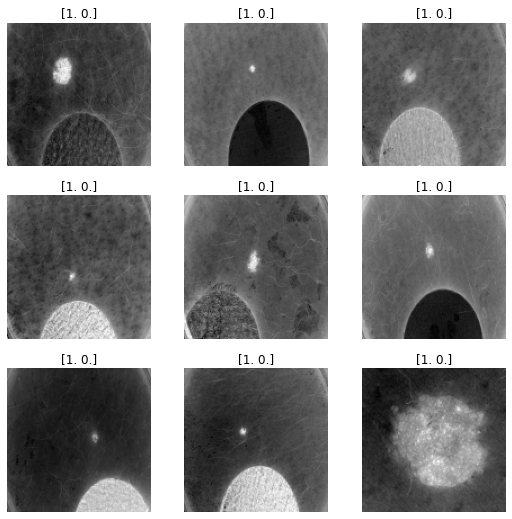

In [17]:
fig,axes = plt.subplots(3,3,figsize=(9,9))
axes_ = axes.flatten()
for i in range(len(axes_)):
    show_image(x_train,i,axes_[i])
    axes_[i].axis('off')
    axes_[i].set_title(y_train[i])
    
plt.show()

## Class balance

In [18]:
np.count_nonzero(y_train[:,0])

1000

In [19]:
np.count_nonzero(y_train[:,1])

1000

# Standardisation

In [20]:
x_test.max()

1.0

In [21]:
x_train = x_train/1.0000008

In [22]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1)

# Model Support functions

In [23]:
def plot_history(history):
    val_acc = history.history['val_accuracy']
    train_acc = history.history['accuracy']
    fig,ax = plt.subplots(figsize=(14,7))
    ax.plot(val_acc,label='validation accuracy')
    ax.plot(train_acc,label='training accuracy')
    ax.legend()
    ax.set_title('Accuracy in train and validation set')
    plt.show()

In [24]:
def compile_fit_evaluate_model(Name,model,
                               X=x_train,
                               y=y_train,
                               epochs=10,
                               batch_size=10,
                               validation_data=(x_val,y_val),
                               evaluation_data = (x_test,y_test),
                               optimizer ='adam',e_stoping=True):
    
    
    log_dir = f'../models/skin_cancer_logs/{Name}'
    tensorboard = TensorBoard(log_dir=log_dir)
    early = EarlyStopping(monitor='val_loss',patience=3)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if e_stoping:
        callback_l =[tensorboard,early]
    else:
        callback_l =[tensorboard]
    history = model.fit(X, 
                        y,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=validation_data,
                       callbacks=callback_l)
    x_test,y_test = evaluation_data 
    print('--------------- Test Accuracy -------------------')
    _, test_acc = model.evaluate(x_test,y_test)
    print(test_acc)
    plot_history(history)
    return history,model

# Simple Model 

In [22]:
NAME = f'128D+24D_{int(time.time())}'

In [23]:
NAME

'128D+24D_1655457185'

In [24]:
simple_model = Sequential(
    [
        Flatten(),
        Dense(128,activation='relu'),
        Dense(24,activation='relu'),
        Dense(2,activation='softmax',name='output_layer'),
    ]
)

2022-06-17 11:13:06.205789: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 11:13:06.206545: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-17 11:13:06.207064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.785GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2022-06-17 11:13:06.207117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-17 11:13:06.207156: I tensorflow/stream_executor/plat

2022-06-17 11:13:07.211946: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 11:13:07.212016: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 11:13:07.212086: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2022-06-17 11:13:07.214008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2022-06-17 11:13:07.314865: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-06-17 11:13:07.315507: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 11:13:07.506745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-17 11:13

Epoch 1/250


2022-06-17 11:13:08.045486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


27/36 [=====================>........] - ETA: 0s - loss: 2.1440 - accuracy: 0.4918

2022-06-17 11:13:08.422435: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 11:13:08.422475: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 11:13:08.423265: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-06-17 11:13:08.428968: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-17 11:13:08.429934: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-17 11:13:08.430575: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 11:13:08.432626: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../models/skin_cancer_logs/128D+24D_165545

36/36 [==============================] - 2s 24ms/step - loss: 1.8810 - accuracy: 0.4965 - val_loss: 1.0544 - val_accuracy: 0.4700
Epoch 2/250
36/36 [==============================] - 0s 5ms/step - loss: 0.8725 - accuracy: 0.4935 - val_loss: 0.7147 - val_accuracy: 0.4700
Epoch 3/250
36/36 [==============================] - 0s 5ms/step - loss: 0.7001 - accuracy: 0.5217 - val_loss: 0.6901 - val_accuracy: 0.6150
Epoch 4/250
36/36 [==============================] - 0s 5ms/step - loss: 0.7043 - accuracy: 0.5661 - val_loss: 0.7571 - val_accuracy: 0.5300
Epoch 5/250
36/36 [==============================] - 0s 5ms/step - loss: 0.7190 - accuracy: 0.5317 - val_loss: 0.7270 - val_accuracy: 0.4800
Epoch 6/250
36/36 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.5646 - val_loss: 0.9927 - val_accuracy: 0.4700
Epoch 7/250
36/36 [==============================] - 0s 5ms/step - loss: 0.7240 - accuracy: 0.5557 - val_loss: 0.9060 - val_accuracy: 0.4700
Epoch 8/250
36/36 [=====

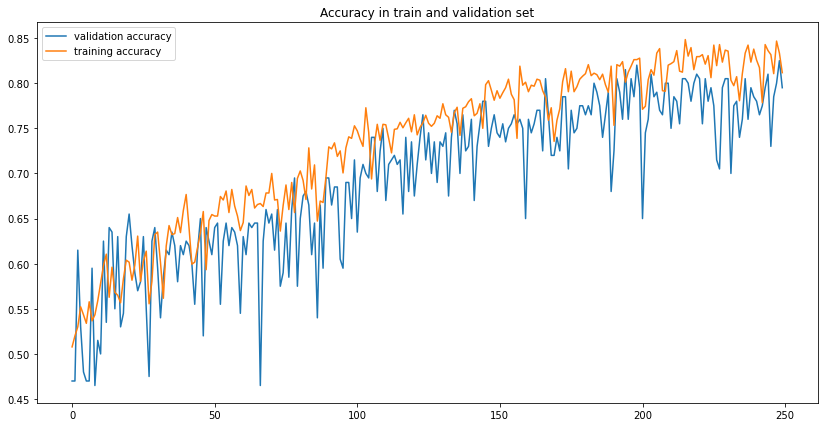

In [25]:
hist,simple_model = compile_fit_evaluate_model(NAME,simple_model,epochs=250,validation_data=(x_val,y_val),batch_size=50)

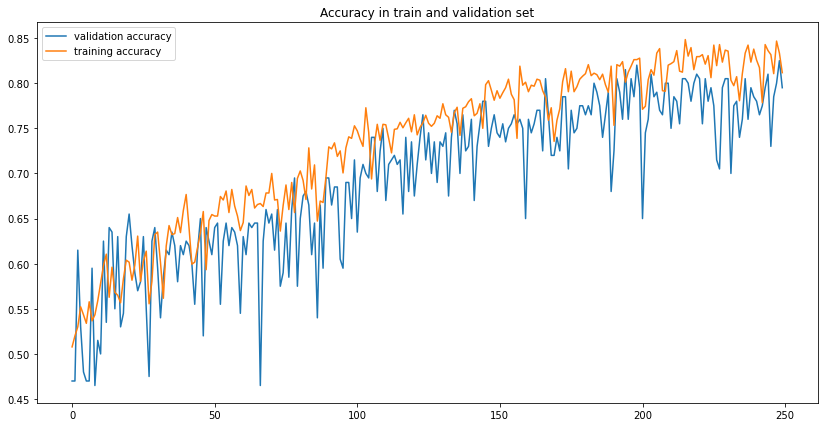

In [26]:
plot_history(hist)

# CNN from kaggle

In [27]:
NAME = f'Model_KG_{int(time.time())}'

In [28]:
model_kg = Sequential()
model_kg.add(Conv2D(filters=4  ,kernel_size=(5,5), strides=(3,3), 
              activation='relu', input_shape=(128,128,1))) 
model_kg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))   
model_kg.add(Conv2D(kernel_size=(5,5), strides=(2,2), 
              filters=4  , activation='relu')) 
model_kg.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))
model_kg.add(Flatten())
model_kg.add(Dense(units=4, activation='tanh'))
model_kg.add(Dense(2, activation='softmax')) 

2022-06-17 11:13:54.749730: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 11:13:54.749772: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 11:13:54.749848: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-17 11:13:54.749872: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/250


2022-06-17 11:13:55.412284: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-17 11:13:57.418790: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-17 11:13:57.540435: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


33/36 [==========================>...] - ETA: 0s - loss: 0.7138 - accuracy: 0.4807

2022-06-17 11:14:01.457474: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 11:14:01.457523: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 11:14:01.457629: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-17 11:14:01.511951: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-17 11:14:01.513247: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-17 11:14:01.513971: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 11:14:01.515217: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../models/skin_cancer_logs/Model_KG_1655457234/tra

36/36 [==============================] - 7s 14ms/step - loss: 0.7122 - accuracy: 0.4812 - val_loss: 0.6911 - val_accuracy: 0.5450
Epoch 2/250
36/36 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5512 - val_loss: 0.6922 - val_accuracy: 0.4700
Epoch 3/250
36/36 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.5243 - val_loss: 0.6890 - val_accuracy: 0.6350
Epoch 4/250
36/36 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.6112 - val_loss: 0.6806 - val_accuracy: 0.5750
Epoch 5/250
36/36 [==============================] - 0s 6ms/step - loss: 0.6711 - accuracy: 0.6110 - val_loss: 0.6674 - val_accuracy: 0.6100
Epoch 6/250
36/36 [==============================] - 0s 6ms/step - loss: 0.6667 - accuracy: 0.6153 - val_loss: 0.6736 - val_accuracy: 0.5950
Epoch 7/250
36/36 [==============================] - 0s 6ms/step - loss: 0.6661 - accuracy: 0.6409 - val_loss: 0.6755 - val_accuracy: 0.5050
Epoch 8/250
36/36 [=====

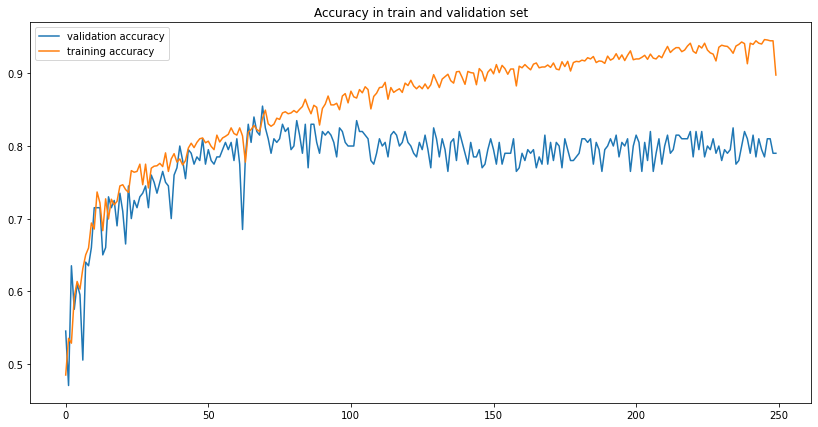

In [29]:
hist,model_kg = compile_fit_evaluate_model(NAME,model_kg,epochs=250,validation_data=(x_val,y_val),batch_size=50)

# VGG-16

For vgg16, it expects 3 channel data to be inputed  
- reshape the data by copying the greyscale channel to 3 channel

## Reshape for vgg

In [25]:
x_train_vgg = np.repeat(x_train,repeats=3,axis=3)
x_test_vgg = np.repeat(x_test,repeats=3,axis=3)
x_val_vgg = np.repeat(x_val,repeats=3,axis=3)

In [26]:
x_train_vgg.shape

(1620, 128, 128, 3)

## Import Vgg

In [27]:
vgg_no_top = VGG16(include_top = False,classes=2,input_shape=(128,128,3))

2022-06-17 13:47:56.732850: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 13:47:56.733767: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-17 13:47:56.734591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.785GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2022-06-17 13:47:56.734682: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-17 13:47:56.734748: I tensorflow/stream_executor/plat

In [28]:
vgg_no_top.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## Modify output for 2 channel clf

In [29]:
x = vgg_no_top.output
flatten_x = Flatten()(x) # add a flatten layer
d_1 = Dense(64,activation='relu')(flatten_x)
predictions = Dense(2, activation='softmax')(d_1)


# Définir le nouveau modèle
vgg_2clf = Model(inputs=vgg_no_top.input, outputs=predictions)
NAME = f'VGG_2clf_{time.time()}'

In [30]:
vgg_2clf.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## Entrainement uniquement du clf et dense

In [31]:
for layer in vgg_no_top.layers[:19]:
    layer.trainable = False

In [32]:
vgg_2clf.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

2022-06-17 13:48:02.002413: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 13:48:02.002490: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 13:48:02.018327: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2022-06-17 13:48:02.098432: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2022-06-17 13:48:02.203066: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-06-17 13:48:02.203745: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 13:48:02.750897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-17 13:48

Epoch 1/10


2022-06-17 13:48:03.972755: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-17 13:48:05.265434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-17 13:48:10.129475: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-17 13:48:10.200664: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-06-17 13:48:11.782745: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 3.33G (3581052160 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


 2/65 [..............................] - ETA: 6s - loss: 0.7296 - accuracy: 0.5700   

2022-06-17 13:48:20.817579: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 13:48:20.817627: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 13:48:20.818496: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-06-17 13:48:20.891556: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-17 13:48:20.915924: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-17 13:48:20.933534: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 13:48:20.959114: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../models/skin_cancer_logs/VGG_2clf_165546

65/65 [==============================] - 44s 414ms/step - loss: 0.5142 - accuracy: 0.7426 - val_loss: 0.5555 - val_accuracy: 0.7222
Epoch 2/10
65/65 [==============================] - 3s 49ms/step - loss: 0.3435 - accuracy: 0.8344 - val_loss: 0.3369 - val_accuracy: 0.8500
Epoch 3/10
65/65 [==============================] - 3s 48ms/step - loss: 0.3144 - accuracy: 0.8593 - val_loss: 0.3437 - val_accuracy: 0.8444
Epoch 4/10
65/65 [==============================] - 3s 48ms/step - loss: 0.2279 - accuracy: 0.9052 - val_loss: 0.3649 - val_accuracy: 0.8667
Epoch 5/10
65/65 [==============================] - 3s 48ms/step - loss: 0.2047 - accuracy: 0.9151 - val_loss: 0.4007 - val_accuracy: 0.8056
--------------- Test Accuracy -------------------


2022-06-17 13:49:01.743552: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2022-06-17 13:49:01.841723: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 3.33G (3581052160 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-06-17 13:49:01.841814: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if

4/4 [==============================] - 23s 4s/step - loss: 0.3586 - accuracy: 0.8500
0.8500000238418579


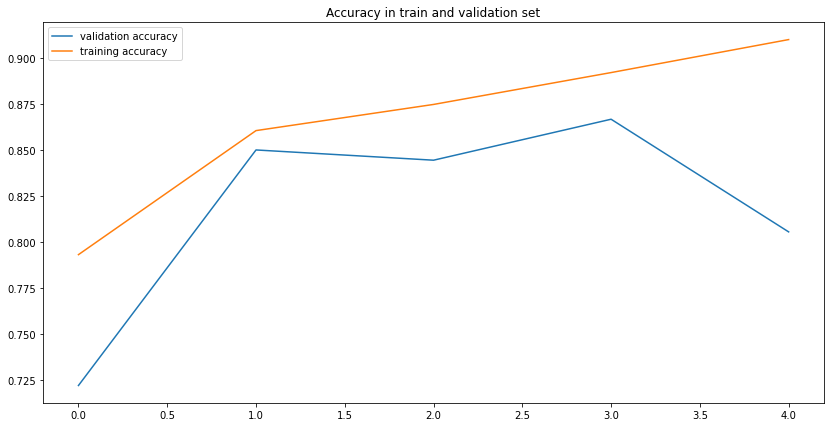

In [33]:
hist,vgg_2clf = compile_fit_evaluate_model(NAME,vgg_2clf,
                                           X=x_train_vgg,
                                           y=y_train,
                                           validation_data=(x_val_vgg,y_val),
                                           evaluation_data=(x_test_vgg,y_test),
                                           batch_size=25,
                                           epochs=10)

## Ajout de couches d'entrainement

In [34]:
vgg_no_top = VGG16(include_top = False,classes=2,input_shape=(128,128,3))

In [35]:
x = vgg_no_top.output
flatten_x = Flatten()(x) # add a flatten layer
d_1 = Dense(32,activation='relu')(flatten_x)
predictions = Dense(2, activation='softmax')(d_1)


# Définir le nouveau modèle
vgg_2clf = Model(inputs=vgg_no_top.input, outputs=predictions)
NAME = f'VGG_2clf_more_tuning_{time.time()}'

In [36]:
for layer in vgg_no_top.layers[:15]:
    layer.trainable = False

In [37]:
vgg_2clf.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

2022-06-17 13:49:24.125453: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 13:49:24.125535: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 13:49:24.125705: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-17 13:49:24.125758: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/10
 2/65 [..............................] - ETA: 5s - loss: 1.0149 - accuracy: 0.5100  

2022-06-17 13:49:27.601931: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 13:49:27.601979: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 13:49:27.602087: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-17 13:49:27.736890: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-17 13:49:27.739209: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-17 13:49:27.740221: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 13:49:27.741690: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../models/skin_cancer_logs/VGG_2clf_more_tuning_16

65/65 [==============================] - 10s 104ms/step - loss: 0.7458 - accuracy: 0.6130 - val_loss: 0.6528 - val_accuracy: 0.5611
Epoch 2/10
65/65 [==============================] - 4s 62ms/step - loss: 0.4411 - accuracy: 0.7732 - val_loss: 1.3360 - val_accuracy: 0.8111
Epoch 3/10
65/65 [==============================] - 4s 62ms/step - loss: 0.4125 - accuracy: 0.8439 - val_loss: 0.4096 - val_accuracy: 0.7833
Epoch 4/10
65/65 [==============================] - 4s 62ms/step - loss: 0.3003 - accuracy: 0.8512 - val_loss: 0.3656 - val_accuracy: 0.8778
Epoch 5/10
65/65 [==============================] - 4s 61ms/step - loss: 0.2962 - accuracy: 0.8831 - val_loss: 0.3585 - val_accuracy: 0.8500
Epoch 6/10
65/65 [==============================] - 4s 62ms/step - loss: 0.2341 - accuracy: 0.9026 - val_loss: 0.4448 - val_accuracy: 0.8500
Epoch 7/10
65/65 [==============================] - 4s 62ms/step - loss: 0.1793 - accuracy: 0.9264 - val_loss: 0.3253 - val_accuracy: 0.8556
Epoch 8/10
65/65 [====

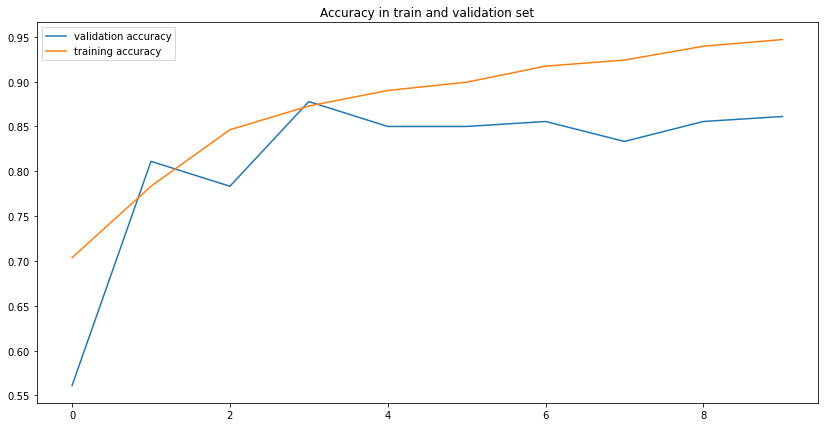

In [38]:
hist,vgg_2clf = compile_fit_evaluate_model(NAME,vgg_2clf,
                                           X=x_train_vgg,
                                           y=y_train,
                                           validation_data=(x_val_vgg,y_val),
                                           evaluation_data=(x_test_vgg,y_test),
                                           batch_size=25,
                                           epochs=10)

## Full train with low training rate

In [39]:
vgg_no_top = VGG16(include_top = False,classes=2,input_shape=(128,128,3))

In [40]:
x = vgg_no_top.output
flatten_x = Flatten()(x) # add a flatten layer
d_1 = Dense(32,activation='relu')(flatten_x)
predictions = Dense(2, activation='softmax')(d_1)


# Définir le nouveau modèle
vgg_2clf_full = Model(inputs=vgg_no_top.input, outputs=predictions)
NAME = f'VGG_2clf_full_tuning_low_lr_10^-7{time.time()}'

In [41]:
vgg_2clf_full.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [42]:
optimizer = Adam(learning_rate = 10e-7)

2022-06-17 13:50:11.801525: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 13:50:11.801601: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 13:50:11.801775: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-17 13:50:11.801826: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/50
 2/65 [..............................] - ETA: 11s - loss: 0.6987 - accuracy: 0.5900  

2022-06-17 13:50:32.025222: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 13:50:32.025269: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 13:50:32.025377: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


 3/65 [>.............................] - ETA: 14s - loss: 0.7099 - accuracy: 0.5667

2022-06-17 13:50:32.275926: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-17 13:50:32.279896: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-17 13:50:32.281333: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 13:50:32.283213: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../models/skin_cancer_logs/VGG_2clf_full_tuning_low_lr_10^-71655466611.6012783/train/plugins/profile/2022_06_17_13_50_32
2022-06-17 13:50:32.284206: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ../models/skin_cancer_logs/VGG_2clf_full_tuning_low_lr_10^-71655466611.6012783/train/plugins/profile/2022_06_17_13_50_32/dataplus02.trace.json.gz
2022-06-17 13:50:32.301711: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating direc

65/65 [==============================] - 49s 450ms/step - loss: 0.7075 - accuracy: 0.5462 - val_loss: 0.5795 - val_accuracy: 0.7667
Epoch 2/50
65/65 [==============================] - 10s 148ms/step - loss: 0.5359 - accuracy: 0.7898 - val_loss: 0.4493 - val_accuracy: 0.8222
Epoch 3/50
65/65 [==============================] - 9s 146ms/step - loss: 0.4361 - accuracy: 0.8166 - val_loss: 0.3903 - val_accuracy: 0.8500
Epoch 4/50
65/65 [==============================] - 9s 146ms/step - loss: 0.3622 - accuracy: 0.8629 - val_loss: 0.3752 - val_accuracy: 0.8278
Epoch 5/50
65/65 [==============================] - 9s 146ms/step - loss: 0.3219 - accuracy: 0.8739 - val_loss: 0.3233 - val_accuracy: 0.8500
Epoch 6/50
65/65 [==============================] - 9s 146ms/step - loss: 0.3028 - accuracy: 0.8747 - val_loss: 0.3286 - val_accuracy: 0.8278
Epoch 7/50
65/65 [==============================] - 10s 147ms/step - loss: 0.2742 - accuracy: 0.8965 - val_loss: 0.3047 - val_accuracy: 0.8389
Epoch 8/50
65/

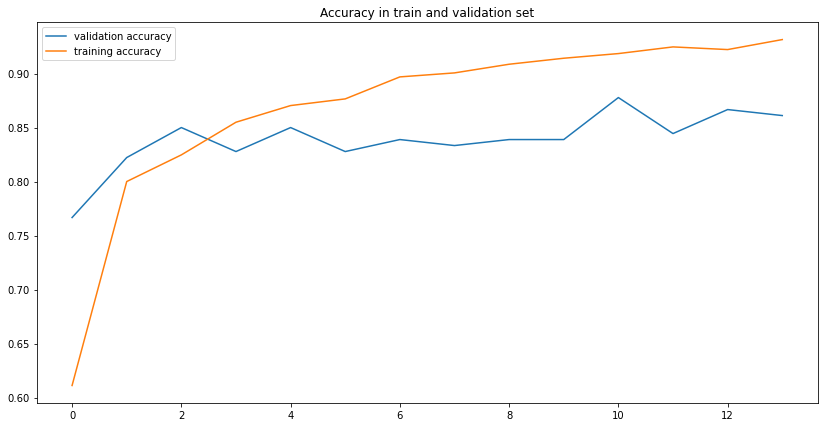

In [43]:
hist,vgg_2clf_full = compile_fit_evaluate_model(NAME,vgg_2clf_full,
                                           X=x_train_vgg,
                                           y=y_train,
                                           validation_data=(x_val_vgg,y_val),
                                           evaluation_data=(x_test_vgg,y_test),
                                           batch_size=25,
                                           epochs=50,
                                          optimizer=optimizer)

# Image augmentation

## Preprocessing layers declaration

In [96]:
aug = Sequential(
    [
        RandomFlip('horizontal_and_vertical'),
        # RandomRotation(0.3),
        RandomContrast(0.3),
    ])

## with kg_model

In [97]:
kg_model_aug = Sequential()
kg_model_aug.add(aug)
kg_model_aug.add(Conv2D(filters=4  ,kernel_size=(5,5), strides=(3,3), 
              activation='relu', input_shape=(128,128,1))) 
kg_model_aug.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))   
kg_model_aug.add(Conv2D(kernel_size=(5,5), strides=(2,2), 
              filters=4  , activation='relu')) 
kg_model_aug.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))
kg_model_aug.add(Flatten())
kg_model_aug.add(Dense(units=4, activation='tanh'))
kg_model_aug.add(Dense(2, activation='softmax')) 

2022-06-17 14:58:11.054445: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 14:58:11.054503: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 14:58:11.054612: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-17 14:58:11.054647: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/250
28/33 [========================>.....] - ETA: 0s - loss: 0.6983 - accuracy: 0.4751

2022-06-17 14:58:11.955438: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 14:58:11.955480: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 14:58:11.955557: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-17 14:58:12.007572: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-17 14:58:12.009272: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-17 14:58:12.010142: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 14:58:12.011491: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../models/skin_cancer_logs/kg_model_img_gen_165547

33/33 [==============================] - 1s 16ms/step - loss: 0.6976 - accuracy: 0.4761 - val_loss: 0.6824 - val_accuracy: 0.5611
Epoch 2/250
33/33 [==============================] - 0s 6ms/step - loss: 0.6866 - accuracy: 0.5165 - val_loss: 0.6897 - val_accuracy: 0.5056
Epoch 3/250
33/33 [==============================] - 0s 7ms/step - loss: 0.6881 - accuracy: 0.5417 - val_loss: 0.6764 - val_accuracy: 0.5944
Epoch 4/250
33/33 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.5834 - val_loss: 0.6667 - val_accuracy: 0.5611
Epoch 5/250
33/33 [==============================] - 0s 7ms/step - loss: 0.6828 - accuracy: 0.5329 - val_loss: 0.6959 - val_accuracy: 0.4778
Epoch 6/250
33/33 [==============================] - 0s 7ms/step - loss: 0.6864 - accuracy: 0.5424 - val_loss: 0.6957 - val_accuracy: 0.4889
Epoch 7/250
33/33 [==============================] - 0s 7ms/step - loss: 0.6853 - accuracy: 0.5489 - val_loss: 0.6745 - val_accuracy: 0.5889
Epoch 8/250
33/33 [=====

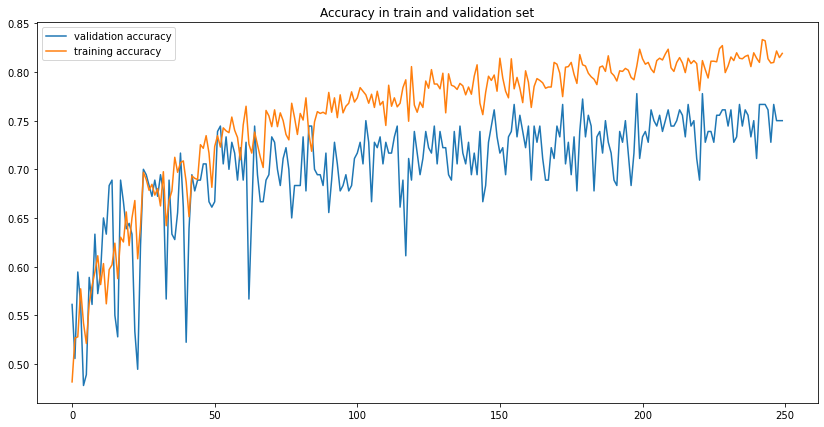

In [98]:
NAME = f'kg_model_img_gen_{int(time.time())}'
hist,kg_model_aug = compile_fit_evaluate_model(NAME,kg_model_aug,epochs=250,validation_data=(x_val,y_val),batch_size=50,e_stoping=False)

# InceptionV3

In [44]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [45]:
incept_base = InceptionV3(include_top=False,
                          weights='imagenet',
                          input_shape=(128,128,3),
                          classes=2)

## Modify output for 2 channel clf

In [46]:
x = incept_base.output
flatten_x = Flatten()(x) # add a flatten layer
d_1 = Dense(64,activation='relu')(flatten_x)
predictions = Dense(2, activation='softmax')(d_1)


# Définir le nouveau modèle
incept_2clf = Model(inputs=incept_base.input, outputs=predictions)
NAME = f'incept_2clf_4l_train_{time.time()}'

In [47]:
for layer in incept_2clf.layers:
    layer.trainable = False

for layer in incept_2clf.layers[-4:]:
    layer.trainable = True

In [51]:
for i,layer in enumerate(incept_2clf.layers):
    print(f'{i-len(incept_2clf.layers)} | {layer.name} | {layer.trainable}')

-314 | input_2 | False
-313 | conv2d_94 | False
-312 | batch_normalization_94 | False
-311 | activation_94 | False
-310 | conv2d_95 | False
-309 | batch_normalization_95 | False
-308 | activation_95 | False
-307 | conv2d_96 | False
-306 | batch_normalization_96 | False
-305 | activation_96 | False
-304 | max_pooling2d_4 | False
-303 | conv2d_97 | False
-302 | batch_normalization_97 | False
-301 | activation_97 | False
-300 | conv2d_98 | False
-299 | batch_normalization_98 | False
-298 | activation_98 | False
-297 | max_pooling2d_5 | False
-296 | conv2d_102 | False
-295 | batch_normalization_102 | False
-294 | activation_102 | False
-293 | conv2d_100 | False
-292 | conv2d_103 | False
-291 | batch_normalization_100 | False
-290 | batch_normalization_103 | False
-289 | activation_100 | False
-288 | activation_103 | False
-287 | average_pooling2d_9 | False
-286 | conv2d_99 | False
-285 | conv2d_101 | False
-284 | conv2d_104 | False
-283 | conv2d_105 | False
-282 | batch_normalization_99 | 

2022-06-17 15:46:33.184981: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 15:46:33.185029: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 15:46:33.185079: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2022-06-17 15:46:33.186313: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2022-06-17 15:46:33.286957: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-06-17 15:46:33.288068: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 15:46:33.796460: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-17 15:46

Epoch 1/25


2022-06-17 15:46:38.808942: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-17 15:46:39.152221: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-17 15:46:40.785798: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-17 15:46:40.877019: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-06-17 15:47:21.101047: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the av

 3/72 [>.............................] - ETA: 11s - loss: 1.3143 - accuracy: 0.6444 

2022-06-17 15:47:22.833884: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 15:47:22.833932: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 15:47:22.834799: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-06-17 15:47:22.873071: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-17 15:47:22.885932: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-17 15:47:22.888951: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 15:47:22.910477: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../models/skin_cancer_logs/incept_2clf_4l_

72/72 [==============================] - 54s 68ms/step - loss: 1.1756 - accuracy: 0.7221 - val_loss: 0.4302 - val_accuracy: 0.8250
Epoch 2/25
72/72 [==============================] - 2s 31ms/step - loss: 0.3303 - accuracy: 0.8514 - val_loss: 0.3758 - val_accuracy: 0.8000
Epoch 3/25
72/72 [==============================] - 2s 31ms/step - loss: 0.2406 - accuracy: 0.9019 - val_loss: 0.6765 - val_accuracy: 0.7950
Epoch 4/25
72/72 [==============================] - 2s 31ms/step - loss: 0.2551 - accuracy: 0.8934 - val_loss: 0.3829 - val_accuracy: 0.8450
Epoch 5/25
72/72 [==============================] - 2s 31ms/step - loss: 0.1773 - accuracy: 0.9255 - val_loss: 0.4627 - val_accuracy: 0.8400
Epoch 6/25
72/72 [==============================] - 2s 31ms/step - loss: 0.1581 - accuracy: 0.9395 - val_loss: 0.4202 - val_accuracy: 0.8300
Epoch 7/25
72/72 [==============================] - 2s 31ms/step - loss: 0.1346 - accuracy: 0.9495 - val_loss: 0.4890 - val_accuracy: 0.8250
Epoch 8/25
72/72 [=====

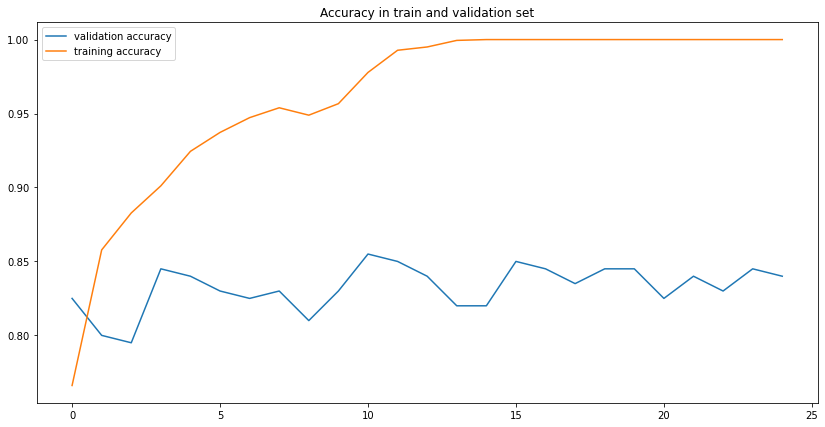

In [31]:
hist,incept_2clf = compile_fit_evaluate_model(NAME,incept_2clf,
                                           X=x_train_vgg,
                                           y=y_train,
                                           validation_data=(x_val_vgg,y_val),
                                           evaluation_data=(x_test_vgg,y_test),
                                           batch_size=25,
                                           epochs=25,e_stoping=False)

## Full train with low lr

In [39]:
x = incept_base.output
flatten_x = Flatten()(x) # add a flatten layer
d_1 = Dense(64,activation='relu')(flatten_x)
predictions = Dense(2, activation='softmax')(d_1)


# Définir le nouveau modèle
incept_2clf = Model(inputs=incept_base.input, outputs=predictions)
NAME = f'incept_2clf_full_train_10-9_{time.time()}'

In [40]:
for layer in incept_2clf.layers:
    layer.trainable = True

In [41]:
optimizer = Adam(learning_rate = 10e-9)

2022-06-17 16:05:33.936507: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 16:05:33.936580: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 16:05:33.936715: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-17 16:05:33.936759: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/10
 2/72 [..............................] - ETA: 21s - loss: 0.6073 - accuracy: 0.5300 

2022-06-17 16:05:42.934240: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 16:05:42.934286: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 16:05:42.934375: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


 4/72 [>.............................] - ETA: 35s - loss: 0.7113 - accuracy: 0.5650

2022-06-17 16:05:43.965009: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-17 16:05:44.001794: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-17 16:05:44.013865: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 16:05:44.022975: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../models/skin_cancer_logs/incept_2clf_full_train_10-9_1655474731.0236113/train/plugins/profile/2022_06_17_16_05_44
2022-06-17 16:05:44.025783: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ../models/skin_cancer_logs/incept_2clf_full_train_10-9_1655474731.0236113/train/plugins/profile/2022_06_17_16_05_44/dataplus02.trace.json.gz
2022-06-17 16:05:44.093603: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../m

72/72 [==============================] - 18s 139ms/step - loss: 0.8198 - accuracy: 0.7286 - val_loss: 1.5700 - val_accuracy: 0.5700
Epoch 2/10
72/72 [==============================] - 7s 95ms/step - loss: 0.3940 - accuracy: 0.8181 - val_loss: 48.8600 - val_accuracy: 0.5850
Epoch 3/10
72/72 [==============================] - 7s 95ms/step - loss: 0.3829 - accuracy: 0.8476 - val_loss: 69.9715 - val_accuracy: 0.5950
Epoch 4/10
72/72 [==============================] - 7s 95ms/step - loss: 0.3399 - accuracy: 0.8579 - val_loss: 0.4717 - val_accuracy: 0.7850
Epoch 5/10
72/72 [==============================] - 7s 95ms/step - loss: 0.3104 - accuracy: 0.8748 - val_loss: 0.7095 - val_accuracy: 0.7250
Epoch 6/10
72/72 [==============================] - 7s 95ms/step - loss: 0.2671 - accuracy: 0.8972 - val_loss: 0.4305 - val_accuracy: 0.8250
Epoch 7/10
72/72 [==============================] - 7s 95ms/step - loss: 0.2770 - accuracy: 0.8865 - val_loss: 0.6478 - val_accuracy: 0.8050
Epoch 8/10
72/72 [==

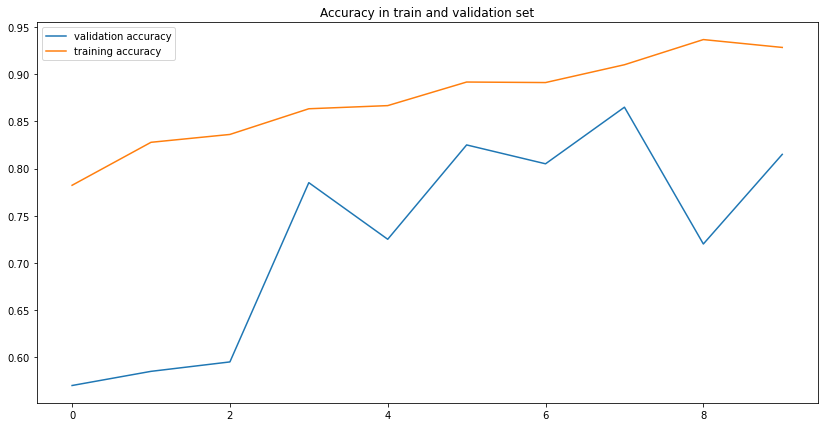

In [42]:
hist,incept_2clf = compile_fit_evaluate_model(NAME,incept_2clf,
                                           X=x_train_vgg,
                                           y=y_train,
                                           validation_data=(x_val_vgg,y_val),
                                           evaluation_data=(x_test_vgg,y_test),
                                           batch_size=25,
                                           epochs=10,e_stoping=False)

In [43]:
for layer in incept_2clf.layers:
    print(f'{layer.name} | {layer.trainable}')

input_1 | True
conv2d | True
batch_normalization | True
activation | True
conv2d_1 | True
batch_normalization_1 | True
activation_1 | True
conv2d_2 | True
batch_normalization_2 | True
activation_2 | True
max_pooling2d | True
conv2d_3 | True
batch_normalization_3 | True
activation_3 | True
conv2d_4 | True
batch_normalization_4 | True
activation_4 | True
max_pooling2d_1 | True
conv2d_8 | True
batch_normalization_8 | True
activation_8 | True
conv2d_6 | True
conv2d_9 | True
batch_normalization_6 | True
batch_normalization_9 | True
activation_6 | True
activation_9 | True
average_pooling2d | True
conv2d_5 | True
conv2d_7 | True
conv2d_10 | True
conv2d_11 | True
batch_normalization_5 | True
batch_normalization_7 | True
batch_normalization_10 | True
batch_normalization_11 | True
activation_5 | True
activation_7 | True
activation_10 | True
activation_11 | True
mixed0 | True
conv2d_15 | True
batch_normalization_15 | True
activation_15 | True
conv2d_13 | True
conv2d_16 | True
batch_normalization_

# Mobile Net

In [65]:
from tensorflow.keras.applications import MobileNetV2

In [66]:
mobile_base = MobileNetV2(input_shape=(128,128,3),classes=2,include_top=False)

In [67]:
x = mobile_base.output
flatten_x = Flatten()(x) # add a flatten layer
d_1 = Dense(64,activation='relu')(flatten_x)
d_2 = Dense(32,activation='relu')(d_1)
drop = Dropout(0.5)(d_2)
predictions = Dense(2, activation='softmax')(drop)


# Définir le nouveau modèle
mobile_2clf = Model(inputs=mobile_base.input, outputs=predictions)
NAME = f'mobile_2clf_2dense_dropout_{time.time()}'

In [68]:
for layer in mobile_base.layers:
    layer.trainable = False

2022-06-17 16:24:42.191397: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 16:24:42.191453: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 16:24:42.191550: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-06-17 16:24:42.191582: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/25
 2/72 [..............................] - ETA: 9s - loss: 1.5256 - accuracy: 0.5400   

2022-06-17 16:25:11.931067: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-17 16:25:11.931120: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-17 16:25:11.931230: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


12/72 [====>.........................] - ETA: 5s - loss: 1.6048 - accuracy: 0.5933

2022-06-17 16:25:12.563005: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-17 16:25:12.575904: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-17 16:25:12.579183: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-17 16:25:12.582872: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../models/skin_cancer_logs/mobile_2clf_2dense_dropout_1655475881.4472864/train/plugins/profile/2022_06_17_16_25_12
2022-06-17 16:25:12.584360: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ../models/skin_cancer_logs/mobile_2clf_2dense_dropout_1655475881.4472864/train/plugins/profile/2022_06_17_16_25_12/dataplus02.trace.json.gz
2022-06-17 16:25:12.638215: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../mod

72/72 [==============================] - 33s 49ms/step - loss: 0.9190 - accuracy: 0.6781 - val_loss: 0.4089 - val_accuracy: 0.7600
Epoch 2/25
72/72 [==============================] - 1s 20ms/step - loss: 0.4138 - accuracy: 0.7969 - val_loss: 0.3851 - val_accuracy: 0.7750
Epoch 3/25
72/72 [==============================] - 1s 20ms/step - loss: 0.3544 - accuracy: 0.8249 - val_loss: 0.4624 - val_accuracy: 0.7200
Epoch 4/25
72/72 [==============================] - 1s 20ms/step - loss: 0.3372 - accuracy: 0.8240 - val_loss: 0.3201 - val_accuracy: 0.8550
Epoch 5/25
72/72 [==============================] - 1s 20ms/step - loss: 0.2660 - accuracy: 0.8712 - val_loss: 0.3572 - val_accuracy: 0.8350
Epoch 6/25
72/72 [==============================] - 1s 20ms/step - loss: 0.2224 - accuracy: 0.8988 - val_loss: 0.3402 - val_accuracy: 0.8500
Epoch 7/25
72/72 [==============================] - 1s 20ms/step - loss: 0.2042 - accuracy: 0.9213 - val_loss: 0.3213 - val_accuracy: 0.8600
Epoch 8/25
72/72 [=====

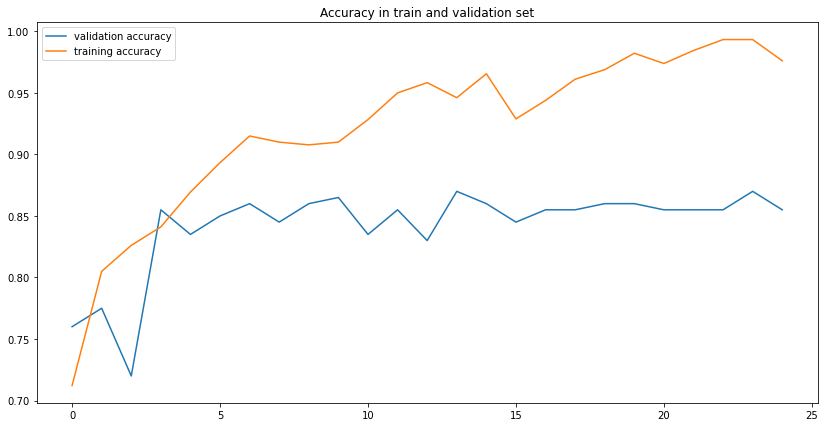

In [69]:
hist,incept_2clf = compile_fit_evaluate_model(NAME,mobile_2clf,
                                           X=x_train_vgg,
                                           y=y_train,
                                           validation_data=(x_val_vgg,y_val),
                                           evaluation_data=(x_test_vgg,y_test),
                                           batch_size=25,
                                           epochs=25,e_stoping=False)